In [1]:
import random
from joblib import Memory
from sklearn import svm
import sklearn.datasets as sd
import scipy.sparse as sparse

In [2]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import pandas as pd

In [3]:
#import dask
#import dask.array as da
#dask.config.set(scheduler='threads')

In [4]:
from sklearn.model_selection import GridSearchCV

In [5]:
def random_index(dataset, old_index = ""):
    new_index = random.randint(0, len(dataset))
    while old_index == new_index:
         new_index = random.randint(0, len(dataset))
    return new_index

## Creating the dataset

In [6]:
filelist = ["./url_svmlight/Day%s.svm" % i for i in range(0,121)]

In [7]:
mem = Memory("./cache")

In [8]:
@mem.cache
def get_data():
    data = sd.load_svmlight_files(filelist)
    return data

In [9]:
data = get_data()

In [10]:
days = np.array([(data[i], data[i+1]) for i in range(0, len(data)) if i%2==0])

In [11]:
days

array([[<16000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 1847536 stored elements in Compressed Sparse Row format>,
        array([-1., -1., -1., ..., -1., -1.,  1.])],
       [<20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2304202 stored elements in Compressed Sparse Row format>,
        array([-1., -1., -1., ..., -1., -1., -1.])],
       [<20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2300129 stored elements in Compressed Sparse Row format>,
        array([-1., -1.,  1., ...,  1.,  1.,  1.])],
       [<20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2302278 stored elements in Compressed Sparse Row format>,
        array([ 1.,  1.,  1., ...,  1., -1., -1.])],
       [<20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2298268 stored elements in Compressed Sparse Row format>,
        array([-1.,  1.,  1., ..., -1.,  1.,  1.])],
       [<20000x3231961 sparse matrix of type '<class 'numpy.

In [12]:
x = np.array([day[0] for day in days])

In [13]:
y = np.array([day[1] for day in days])

In [14]:
for i in range(0, len(x)):
    if x[i].shape != (20000, 3231961):
        print(i)

0
45


In [15]:
x = np.delete(x, 0)
x = np.delete(x, 44)
y = np.delete(y, 0)
y = np.delete(y, 44)

In [16]:
for i in range(0, len(x)):
    if x[i].shape != (20000, 3231961):
        print(i)

In [17]:
x

array([<20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2304202 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2300129 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2302278 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2298268 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2305094 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2318747 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2350415 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.flo

In [18]:
y

array([array([-1., -1., -1., ..., -1., -1., -1.]),
       array([-1., -1.,  1., ...,  1.,  1.,  1.]),
       array([ 1.,  1.,  1., ...,  1., -1., -1.]),
       array([-1.,  1.,  1., ..., -1.,  1.,  1.]),
       array([-1.,  1.,  1., ...,  1., -1., -1.]),
       array([-1., -1., -1., ..., -1., -1.,  1.]),
       array([-1., -1.,  1., ...,  1., -1., -1.]),
       array([ 1., -1., -1., ...,  1., -1., -1.]),
       array([-1., -1., -1., ...,  1., -1., -1.]),
       array([-1., -1.,  1., ..., -1.,  1.,  1.]),
       array([-1., -1., -1., ...,  1.,  1., -1.]),
       array([-1., -1., -1., ..., -1., -1., -1.]),
       array([-1.,  1.,  1., ...,  1., -1., -1.]),
       array([-1.,  1., -1., ...,  1., -1., -1.]),
       array([ 1.,  1.,  1., ..., -1., -1., -1.]),
       array([-1.,  1., -1., ...,  1.,  1.,  1.]),
       array([ 1., -1.,  1., ...,  1., -1.,  1.]),
       array([ 1., -1., -1., ..., -1., -1.,  1.]),
       array([-1., -1., -1., ..., -1., -1., -1.]),
       array([-1., -1., -1., ..

In [19]:
#da_days = da.from_array(days, chunks=(7000, 7000))

# Exploratory view on the URLs

In [20]:
totalurls = np.empty(0)

for day in days:
    totalurls =np.append(totalurls, day[1])

In [21]:
totalurls

array([-1., -1., -1., ...,  1., -1., -1.])

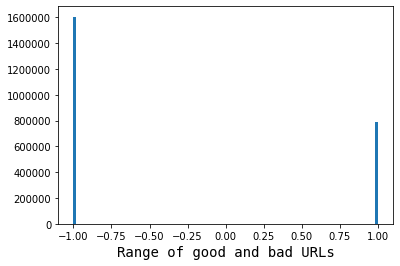

In [23]:
plt.hist(totalurls, 100)
plt.xlabel("Range of good and bad URLs", fontdict={'fontsize': 14, 'family': 'monospace'})
plt.show()

# Fitting model on raw data

## SVM

In [24]:
from dask_ml.model_selection import GridSearchCV

In [26]:
from sklearn.model_selection import train_test_split

In [25]:
estimator = svm.SVC(gamma='auto', random_state=0, probability=True)

param_grid = {
    'C': [0.1, 1.0, 20.0, 100.0],
    'kernel': ['rbf', 'poly', 'linear'],
}

grid_search = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=2)

## Train test split

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.3)

/home/giordano/anaconda3/envs/da2019/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [116]:
x_train

array([<20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2299309 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2300129 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2302256 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2340800 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2355553 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2318747 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2347018 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.flo

First apply grid search model to find the best parameters to svm

In [31]:
grid_search = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=2)

In [32]:
index = random.randint(0, len(x_train)) 

In [33]:
%time grid_search.fit(x_train[index], y_train[index])

CPU times: user 1h 18min 58s, sys: 15.1 s, total: 1h 19min 13s
Wall time: 22min 29s


GridSearchCV(cache_cv=True, cv=2, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False),
       iid=True, n_jobs=-1,
       param_grid={'C': [0.1, 1.0, 20.0, 100.0], 'kernel': ['rbf', 'poly', 'linear']},
       refit=True, return_train_score='warn', scheduler=None, scoring=None)

In [69]:
pd.DataFrame(grid_search2.cv_results_)

/home/giordano/anaconda3/envs/da2019/lib/python3.6/site-packages/dask_ml/model_selection/utils.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in sklearn 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/giordano/anaconda3/envs/da2019/lib/python3.6/site-packages/dask_ml/model_selection/utils.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in sklearn 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/giordano/anaconda3/envs/da2019/lib/python3.6/site-packages/dask_ml/model_selection/utils.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in sklearn 0.21. If you need training scores, please set return_train_score=Tru

,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score,param_C,param_kernel
0,"{'C': 0.1, 'kernel': 'rbf'}",287.717076,0.238698,48.722722,0.027018,0.6770,0.6770,0.67700,0.00000,6,0.6770,0.6770,0.6770,0.0000,0.1,rbf
1,"{'C': 0.1, 'kernel': 'poly'}",270.936259,2.517677,40.392232,0.321165,0.6770,0.6770,0.67700,0.00000,6,0.6770,0.6770,0.6770,0.0000,0.1,poly
2,"{'C': 0.1, 'kernel': 'linear'}",48.920876,5.378895,7.708634,0.054018,0.9836,0.9820,0.98280,0.00080,1,0.9991,0.9989,0.9990,0.0001,0.1,linear
3,"{'C': 1.0, 'kernel': 'rbf'}",312.948779,2.221242,50.013410,0.522697,0.6770,0.6770,0.67700,0.00000,6,0.6770,0.6770,0.6770,0.0000,1,rbf
4,"{'C': 1.0, 'kernel': 'poly'}",271.050207,1.548006,42.146087,0.603089,0.6770,0.6770,0.67700,0.00000,6,0.6770,0.6770,0.6770,0.0000,1,poly
5,"{'C': 1.0, 'kernel': 'linear'}",42.206410,0.882814,6.214107,0.597595,0.9832,0.9817,0.98245,0.00075,2,1.0000,1.0000,1.0000,0.0000,1,linear
6,"{'C': 20.0, 'kernel': 'rbf'}",325.010774,3.499314,53.640535,1.272588,0.6770,0.6770,0.67700,0.00000,6,0.6770,0.6770,0.6770,0.0000,20,rbf
7,"{'C': 20.0, 'kernel': 'poly'}",274.124039,1.979885,49.443014,4.305748,0.6770,0.6770,0.67700,0.00000,6,0.6770,0.6770,0.6770,0.0000,20,poly
8,"{'C': 20.0, 'kernel': 'linear'}",42.483388,2.738713,6.922708,0.394217,0.9825,0.9816,0.98205,0.00045,3,1.0000,1.0000,1.0000,0.0000,20,linear
9,"{'C': 100.0, 'kernel': 'rbf'}",317.728947,4.355591,54.637758,0.753373,0.7822,0.7739,0.77805,0.00415,5,0.8239,0.7729,0.7984,0.0255,100,rbf


In [37]:
grid_search.best_params_

{'C': 0.1, 'kernel': 'linear'}

In [38]:
grid_search.best_estimator_

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)

In [40]:
grid_search.score(x_test[7], y_test[7])

0.95055

In [41]:
%time result = grid_search.predict(x_test[25])

CPU times: user 16 s, sys: 8.08 ms, total: 16 s
Wall time: 16 s


In [42]:
np.array_equal(result, y_test[25])

False

In [43]:
np.sum(result == y_test[25])

19470

In [44]:
np.sum(result != y_test[25])

530

Train the model with other random urls from the training set

In [63]:
index2 = random_index(x_test, index)

In [64]:
grid_search.fit(x_test[index2], y_test[index2])

GridSearchCV(cache_cv=True, cv=2, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False),
       iid=True, n_jobs=-1,
       param_grid={'C': [0.1, 1.0, 20.0, 100.0], 'kernel': ['rbf', 'poly', 'linear']},
       refit=True, return_train_score='warn', scheduler=None, scoring=None)

In [65]:
grid_search.best_params_

{'C': 0.1, 'kernel': 'linear'}

In [67]:
index_test = random_index(x_test)
grid_search.score(x_test[index_test], y_test[index_test])

0.9666

In [70]:
index_test2 = random_index(x_test, index_test)
grid_search.score(x_test[index_test2], y_test[index_test2])

0.9723

In [71]:
index3 = random_index(x_train, index2)

Training with a smaller dataset

In [89]:
%time grid_search.fit(x_train[index3][:15000,:], y_train[index3][:15000,])

CPU times: user 1h 1min 55s, sys: 7.51 s, total: 1h 2min 3s
Wall time: 17min 27s


GridSearchCV(cache_cv=True, cv=2, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False),
       iid=True, n_jobs=-1,
       param_grid={'C': [0.1, 1.0, 20.0, 100.0], 'kernel': ['rbf', 'poly', 'linear']},
       refit=True, return_train_score='warn', scheduler=None, scoring=None)

In [92]:
index_test4 = random_index(x_test, index_test3)
grid_search.score(x_test[index_test4], y_test[index_test4])

0.9624

# Test on preprocessed data

## Truncated SVD

In [19]:
from sklearn.decomposition import TruncatedSVD

In [20]:
mem_svd = Memory('./cache_svd')

In [24]:
@mem_svd.cache
def get_svd_array(dataset):
    svd = TruncatedSVD(n_components=10)
    svd_dataset = np.array([svd.fit_transform(day) for day in dataset])
    return svd_dataset

In [ ]:
svd_x = get_svd_array(x)

________________________________________________________________________________
[Memory] Calling __main__--home-giordano-Documenti-Universita-seas-Primo anno - secondo semestre-Data-Analitycs-Data-Analysis-project-__ipython-input__.get_svd_array...
get_svd_array(array([<20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2304202 stored elements in Compressed Sparse Row format>,
       ...,
       <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2302256 stored elements in Compressed Sparse Row format>],
      dtype=object))
